<h2 align="right"> Felix Filipi</h2>
<h2 align="right"> 2301877590</h2>

<h1 align="center">Computer Vision</h1>
<h1 align="center">Instance Retrieval</h1>

<h3> Before we go any further, let's import all needed library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.cluster import KMeans

<b> Now let's go to the first instruction.</b>

<h2>1. Selecting representative images from an image dataset (https://github.com/willard-yuan/image-retrieval/tree/master/bag-of-words-python-dev-version)</h2>

As far as I understand we're asked to download the dataset from the provided github links. So, to do this, first we need to go to the link above and find the dataset, once you've found the dataset, you can copy the link and paste it in https://downgit.github.io/, and you just need to paste your link.

Download the dataset from that link, and now we need to unzip this file. And here's the code to unzip this file.

In [2]:
with ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("dataset")

<b>After unzipping the file, we need to load the dataset. Let's specify where's the dataset directory.

In [3]:
dir_name = 'dataset/dataset/train'

Now once we've done specify the directory, we need to read and load all image in the directory. To load this dataset you just need to implement the code below:

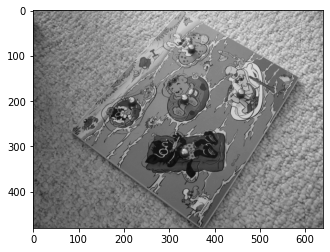

In [4]:
images = []
for images_path in os.listdir(dir_name):
    image = cv2.imread(dir_name + '/' + images_path,0) #read as grayscale
    images.append(image)

plt.imshow(images[0], cmap="gray")

<h2>2. Collect all the SIFT descriptors from the images in 1</h2>

Now, we're asked to collect all descriptor from the images using SIFT algorithm. This is how you get all descriptor from the images using opencv2.

In [5]:
descriptor_list = []

sift = cv2.SIFT_create()
for image in images:
    keypoint, descriptor = sift.detectAndCompute(image, None)
    descriptor_list.append(descriptor)
    
# convert list to array, since kmeans not take list as input
desc = np.concatenate(descriptor_list) 
desc.shape

(107198, 128)

<h2>3. Cluster these descriptors using K Means into k number of clusters where k is a number your set. The center of these clusters are the "visual words" i.e. representative features in your database of images.</h2>

Now, we need to cluster each descriptor using K-Means algorithm, where k is the number of your set. Now, just to make it clear, as far as I know, <b>each cluster will represent different images. Each cluster will act as bag of visual word, so each cluster will represent 1 type of image.</b> So because we've 14 different type of image, we need to specify only 14 cluster.

In [6]:
cluster = KMeans(n_clusters=14).fit(desc)

centroids = cluster.cluster_centers_

print('Total centroids = ',len(centroids))
print(centroids)

Total centroids =  14
[[25.925852  21.382383  21.534044  ... 19.047718  19.178698  23.11084  ]
 [37.687687  24.686758  15.852568  ... 18.363039  13.933565  22.74715  ]
 [15.326944  11.923696  12.208463  ...  6.614031   5.8068027 14.972844 ]
 ...
 [17.336864  16.941948  21.830917  ... 17.545183  14.625334  15.05355  ]
 [37.531616  43.881905  30.686968  ... 10.778681   7.204789  11.810894 ]
 [16.884136   9.183963   7.8538485 ... 13.958683   9.725513  14.535693 ]]


<h2>4. For every image in the database, you are going to create a vector V that counts how frequently the different features in the dictionary occurs so each image would be represented by a vector in the form of: <# times feature 1 in dictionary occur, ... feature 2 in dictionary occur..., ..., ... feature k in dictionary occur> i.e., a k dimensional vector. You obtain this vector for an image by: </h2>

### 4.1. Extracting SIFT descriptors in the image

### 4.2. For each SIFT descriptor in the image, find the closest cluster center (using Euclidean distance) in the codebook/dictionary and increment its corresponding count in the vector v by 1.


Yeah it's sound a litte bit complicated. The point is, we are asked to do something like this.


<b>E.g., you have a 5 cluster dictionary (e.g., k = 5) and an image has 3 SIFT descriptors. Two (2) of them are closest to the first cluster center and 1 is closest to the fifth cluster center. Your vector V would be V = <2, 0, 0, 0, 1>. Since V counts the number of times the representative vectors occur in an image, V is sometimes also referred to as a frequency histogram.

To do this, first we need to find all distance between descriptor and centroid. So, how to get the distance? To find it out, we need know the shape of the array between each descriptor and centroid, once we've know that both shape is equal, we can compute the distance between them.

In [7]:
print(desc[0].shape)
print(centroids[0].shape)

(128,)
(128,)


### Now we've know which variable need to be calculated. Now, let's find the closest distance and also the closest centroid between descriptor and centroids and map it to the vector

In [8]:
# define euclediance distance function
def euclidean_distance(a,b):
    distance = np.linalg.norm(a-b)
    return distance

# init empty list as the result
vectors = []

# for each descriptor in each image
for i in range(len(images)):
    count = np.zeros(len(centroids))
    
    # descriptor for each image
    for descriptor in descriptor_list[i]:

        # initialize 0 as closest centroid
        closest_centroid = 0

        # for each index of centroid
        for index in range(len(centroids)):

            # find the distance between the descriptor and indexed centroid / current centroid
            distance = euclidean_distance(descriptor, centroids[index])

            # if the distance less than distance between closest centroid
            if(distance < euclidean_distance(descriptor, centroids[closest_centroid])):

                # swap the current centroid as closest centroid and distance
                closest_centroid = index
            
            count[closest_centroid] += 1

    # after all centroid gained, append to the list
    vectors.append(count)

## 5. At this stage, you might want to normalize the histogram by dividing each entry by the sum of all the entries so that images with very different number of SIFT key-points found can be made comparable.

We're asked to normalize the data, and actually this instruction means that we need to normalize it using MinMaxScaler, but let's just do the same way as it asked.

In [9]:
normalized_hist = []

for entries in vectors:
    
    # dividing each entry by the sum of all entries
    normalized = entries/sum(vectors)
    normalized_hist.append(normalized)

# convert list to array
normalized_hist = np.array(normalized_hist)

## 6. Now, to compare 2 images, you compare this new vector V instead of the SIFT descriptors themselves. It is recommended to use cosine similarity to evaluate how close your query image with images in the database.

Input your query ID = 50


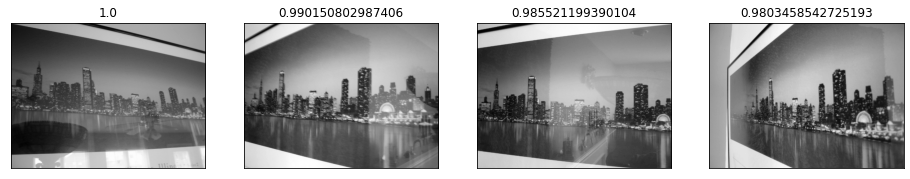

In [10]:
def cosine_similarity(a, b):
    distance = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return distance

query = int(input('Input your query ID = '))

distance = []
for i in range(len(images)):
    dist = cosine_similarity(normalized_hist[i],normalized_hist[query])
    distance.append(dist)

plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[np.flip(np.argsort(distance))[i]], cmap='gray')
    plt.title(distance[np.flip(np.argsort(distance))[i]])
    plt.xticks([]),plt.yticks([])